# Image registration
## Introduction
Image registration is the process of aligning two images.  It involves moving (or deforming) one image, i.e. the floating image, such that it matches the best to a reference or fixed image.  In the image-based data mining methodology, it is used to align, or map, all patient data into a reference frame of reference. 

In the this notebook, we will see how to perform image registration using the insight toolkit (ITK).  We will use a simplified version, SimpleITK.


# Preparatory steps
Let's start setting up the notebook:

In [1]:
%matplotlib notebook

## Make the notebook use full width of display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
%%javascript
// this cell stops the notebook from putting ouput in scrolling frames, which I find really annoying
IPython.OutputArea.prototype._should_scroll = function(lines){return false;}

<IPython.core.display.Javascript object>

Let's import all libraries we need:

In [3]:
import SimpleITK as sitk        # for the registration
import os                       # for file management
import os.path                  # for file management
import matplotlib.pyplot as plt # for plotting the metric
from ipywidgets import interact, fixed  #for plotting the registered image
from numpy import sign, zeros, max


We will be plotting the metric of the function as the registration is doing its job. For that we need to set up some functions:

In [5]:
def start_plot():
    global metric_values, optimiser_iterations, fig, ax
    optimiser_iterations = []
    metric_values = []
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    
    
def plot_values(registration_method):
    global metric_values, optimiser_iterations, fig, ax
    optimiser_iterations.append(registration_method.GetOptimizerIteration())
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear and plot the similarity metric values
    ax.clear()
    #ax.plot(optimiser_iterations, metric_values, 'b.')
    ax.plot( metric_values, 'b.')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    ax.set_ylim([-1, 0])
    fig.canvas.draw()
    
def command_multires_iterations():
    print("    > ---- Resolution change ----")


Let's also define a function to visualize the images after registration.

In [6]:
# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images( referenceImage, floatingAfterResample):
    ref = sitk.GetArrayFromImage(referenceImage)
    flo = sitk.GetArrayFromImage(floatingAfterResample)

    rgbimg = zeros((*ref.shape,3))
    rgbimg[...,0]=ref/max(ref);
    rgbimg[...,1]=flo/max(ref);
    rgbimg[...,2]=ref/max(ref);
    
    figi = plt.figure()
    axi = figi.add_subplot(131)
    axi.imshow(rgbimg[:,64,:,:])
    axi.axis('off')
    axi = figi.add_subplot(132)
    axi.imshow(rgbimg[50,:,:,:])
    axi.axis('off')
    axi = figi.add_subplot(133)
    axi.imshow(rgbimg[:,:,64,:])
    axi.axis('off')
    plt.ion()
    figi.show()


Let's set up some misc. variables.

In [7]:
imgfolder = "./data/DownsampledImages/"
dataDir = imgfolder
nrrOutput = imgfolder + "../warpedImgs/"

referenceImagePath = imgfolder + "0002.nii"
referenceMaskPath = imgfolder + "../0002_mask_ds.nii"

## Affine registration
The first step to register any pair of images is to globally align them. This is achieved using Rigid or Affine registration.

In this function, all elements for an affine registration will be set-up. The elements include:
-  The **metric**:  This element is used to determine how similar two images are.  In this example, we will use the (negative) normalized cross corelation.
-  The **interpolator**: we use a linear interpolator.  A good balance between speed and performance. 
-  The **reference mask**: to filter the voxels in the image that matter for the registation.  The mask we will use was semi-automatically created, and focuses on the head and neck area, ignoring the shoulders and thorax.
-  The **optimiser**: we chose regular step grandient descent.  Change the values of the arguments to see how fast/slow the optimiser converges (if it does!)
-  The **transform**:  we chose the 'Similarity 3D Transform'.  This transforms allows translation, rotation and scaling. The choice of the transform defines whether the registation is affine, rigid or non-rigid!  Notice we are optimising 7 parameters, 3 translations, 3 rotations and scaling.

This function returns the transform parameters that minimised the metric the most!  


In [16]:
def run_affine_registration(referenceImage, referenceMask, floatingImage, printInfo=True):
    R = sitk.ImageRegistrationMethod()
    R.SetMetricAsCorrelation()
    R.SetInterpolator(sitk.sitkLinear)
    R.SetMetricFixedMask(referenceMask)
    
    R.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                               minStep=1e-2,
                                               numberOfIterations=200,
                                               gradientMagnitudeTolerance=1e-2,
                                               maximumStepSizeInPhysicalUnits = 10)
    R.SetOptimizerScalesFromIndexShift()

    tx = sitk.CenteredTransformInitializer(referenceImage, floating, sitk.Similarity3DTransform() )
    print("Initial Number of Parameters: {0}".format(tx.GetNumberOfParameters()))

    R.SetInitialTransform(tx)

    R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

    outTx = R.Execute(referenceImage, floatingImage)

    if printInfo:
        print("    >> Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
        print("    >> Iteration: {0}".format(R.GetOptimizerIteration()))
        print("    >> Metric value: {0}".format(R.GetMetricValue()))

    return outTx

## Non-rigid Registration
Non-rigid registration, also known as deformable registration, helps to fine-tune the image alignment by allowing the image to be deformed. 

Similarly to the affine registration, all elements are defined in this function.  Additionally, we allow for a multi-resolution approach to speed-up and improve the registration results.

The elements include:
-  The **metric**: This element is used to determine how similar two images are.  In this example, we will use the (negative) normalized cross corelation.
-  The **interpolator**: we use a linear interpolator.  A good balance between speed and performance. 
-  The **reference mask**: to filter the voxels in the image that matter for the registation.  The mask we will use was semi-automatically created, and focuses on the head and neck area, ignoring the shoulders and thorax.
-  The **optimiser**: we chose a different optimiser to allow the many parameters be optimised in a decent time.  We chose the Limited memory Broyden Fletcher Goldfarb Shannon minimization (LBFGSB).
-  The **transform**:  we chose the BSpline transform. It uses a sparse set of control points to control a free form deformation. This choice of the transform defines the registation to be non-rigid!  Notice we are optimising many more parameters than the affine registration... How many?
- The **multi-resolution scheme**: it is defined by the ShrinkFactorPerLevel and SmoothingSigmaPerLevel.  The size of the argument array defines how many levels are to be used. Note that this only happens if the argument UseMultiResolution is set to true.  Could you add multi-resolution to the affine registration?

This function returns the transform parameters that minimised the metric the most!  

In [17]:
def run_nonrigid_registration(referenceImage, referenceMask, floatingImage, useMultiResolution=True, printInfo=True):
    R = sitk.ImageRegistrationMethod()
    R.SetMetricAsCorrelation()
    R.SetInterpolator(sitk.sitkLinear)
    R.SetMetricFixedMask(referenceMask)
        
    R.SetOptimizerAsGradientDescentLineSearch(5.0,
                                          100,
                                          convergenceMinimumValue=1e-4,
                                          convergenceWindowSize=5)
    # try a different optimiser?
    #R.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5,
    #                   numberOfIterations=100,
    #                   maximumNumberOfCorrections=5,
    #                   maximumNumberOfFunctionEvaluations=200,
    #                   costFunctionConvergenceFactor=1e+7)
    
    transformDomainMeshSize=[8]*floatingImage.GetDimension()
    tx = sitk.BSplineTransformInitializer(referenceImage, transformDomainMeshSize )
    
    print("Initial Number of Parameters: {0}".format(tx.GetNumberOfParameters()))
    R.SetInitialTransform(tx, True)
    
    R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))
    
    if useMultiResolution:
        R.SetShrinkFactorsPerLevel([8,4,2,1])
        R.SetSmoothingSigmasPerLevel([4,2,1,0])
        R.AddCommand(sitk.sitkMultiResolutionIterationEvent, lambda: command_multires_iterations() )
    
    outTx = R.Execute(referenceImage, floatingImage)

    if printInfo:
        print("    >> Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
        print("    >> Iteration: {0}".format(R.GetOptimizerIteration()))
        print("    >> Metric value: {0}".format(R.GetMetricValue()))

    return outTx

## Resampler
Last, but not least, the function that applies the found tranformation (affine or non-rigid) to an image (or dose distribution). 

In [18]:
def resample_image_with_Tx(referenceImage, Tx, iimg):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(referenceImage);
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(Tx)
    oimg = resampler.Execute(iimg)
    return oimg

## Let's set the ball to roll.  

First let's read the reference image.  In this case, it is the CT of the reference patient.  We chose 0002 and made a mask for it.

In [19]:
referenceImage = sitk.ReadImage(referenceImagePath, sitk.sitkFloat32)
referenceMask = sitk.ReadImage(referenceMaskPath)   

We can chose whether we want to do multiresolution in the registration by changing the value of this variable.  Multiresolution constructs an 'image pyramid', were each level is smaller than the next.  This helps the registration evade local minima, and allows it to run faster (at least in theory) by allowing the optimiser converge faster. 

In [21]:
useMultiRes = False

Let's now choose the other patient to be registered.  Choose other images to see how the registration works with them.

In [22]:
img = "0004.nii"

This is the where all gets to work together:
1. the floating image is read.  If the image is acquired in a different direction than the reference image, the image is flipped.  
2. the affine registration is performed, and an image resampled in the same grid as the reference image is created (floatingAfterAffine).
3. The non-rigid registration is performed.  The image is resample with the new pairs of parameters (out), and saved
4. The dose distribution is loaded, flipped if required, and resampled first with the affine transformation and then with the non-rigid transformation.  Then the warped dose is saved.

0004.nii starting!


<IPython.core.display.Javascript object>


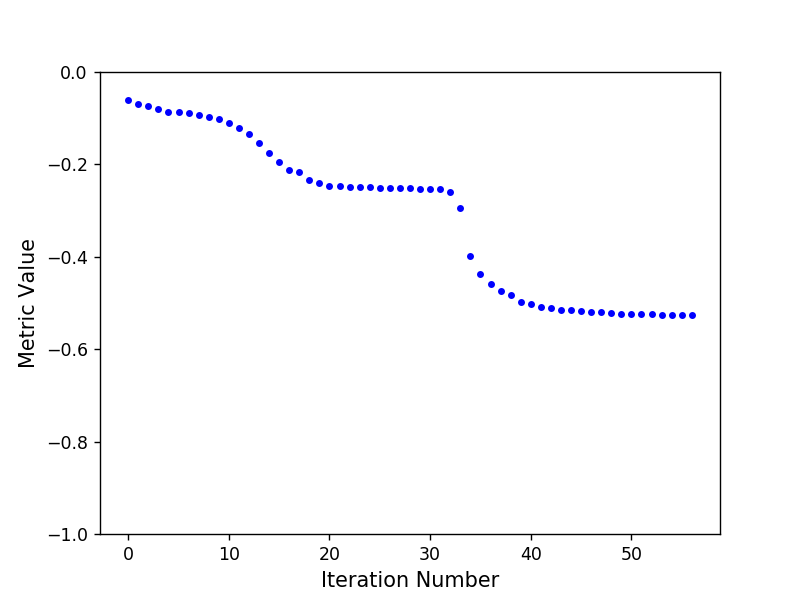

(i) Floating image was flipped
---- Affine part ----
Initial Number of Parameters: 7
    >> Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 30 iterations. Gradient magnitude (0.00931866) is less than gradient magnitude tolerance (0.01).
    >> Iteration: 31
    >> Metric value: -0.2530704659225556
---- Non-Rigid part ----
Initial Number of Parameters: 3993
    >> Optimizer stop condition: GradientDescentLineSearchOptimizerv4Template: Convergence checker passed at iteration 27.
    >> Iteration: 27
    >> Metric value: -0.5267901289567021
---- Resampling image ----
0004.nii done!


In [23]:
print(img + " starting!")
start_plot()

# STEP 1
floating = sitk.ReadImage(os.path.join(dataDir, img), sitk.sitkFloat32)    
# Flip if needed HFS vs FFS
flipped = False
if( sign(floating.GetDirection()[-1]) != sign(referenceImage.GetDirection()[-1]) ):
    print("(i) Floating image was flipped")
    floating = sitk.Flip(floating, [False, False, True])
    flipped = True

# STEP 2: register the images allowing only rotations, translations and scaling
print("---- Affine part ----")
affineTx = run_affine_registration(referenceImage, referenceMask, floating )
# print(affineTx)
floatingAfterAffine = resample_image_with_Tx(referenceImage, affineTx, floating)

# STEP 3: register the images non-rigidly
print("---- Non-Rigid part ----")
nrrTx = run_nonrigid_registration(referenceImage, referenceMask, floatingAfterAffine, useMultiRes )
# print(nrrTx)

# Let's resample the image with the B-Spline found
print("---- Resampling image ----")
out = resample_image_with_Tx(referenceImage, nrrTx, floatingAfterAffine)

# Cast and save
outshort = sitk.Cast(out, sitk.sitkInt16)
sitk.WriteImage(outshort, os.path.join(nrrOutput,img))

print(img + " done!")


In [ ]:
display_images( referenceImage, floatingAfterAffine)
display_images( referenceImage, out)